In [116]:
import os
import re
from io import StringIO
from typing import Optional
import numpy as np
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [117]:
import re
from io import StringIO
from typing import Optional, List, Tuple

import numpy as np
import pandas as pd


# ------------------------------- #
# 1) FILE PARSING HELPERS
# ------------------------------- #

def _read_lines(filepath: str) -> List[str]:
    """Read a text/CSV file into a list of lines."""
    with open(filepath, "r", encoding="utf-8", errors="replace") as f:
        return f.read().splitlines()


def _find_header_index(lines: List[str]) -> int:
    """
    Locate the first line that looks like the logger header:
    e.g., 'Frame, Sub Frame, ...'
    """
    header_pat = re.compile(r"^\s*Frame\s*,\s*Sub\s*Frame\b", re.IGNORECASE)
    for i, line in enumerate(lines):
        if header_pat.search(line):
            return i
    raise ValueError("Header line starting with 'Frame, Sub Frame' was not found.")


def _truncate_at_next_devices(lines: List[str], start: int) -> List[str]:
    """
    From the header line onward, optionally cut at the next 'Devices' line
    (some logs repeat a preface block later).
    """
    dev_pat = re.compile(r"^\s*['\"]?\s*Devices\b", re.IGNORECASE)
    for j in range(start + 1, len(lines)):
        if dev_pat.search(lines[j]):
            return lines[start:j]
    return lines[start:]


def _read_block_to_df(block_lines: List[str]) -> pd.DataFrame:
    """
    Build a DataFrame from the selected text block.
    Also drop an immediate 'units' row if present (e.g., ',,V,V,V,...').
    """
    df = pd.read_csv(StringIO("\n".join(block_lines)), header=0)

    if df.empty:
        return df

    # Detect a units row directly under the header
    first_row = df.iloc[0].astype(str).str.strip().tolist()
    unit_like = re.compile(r"^[A-Za-zµμ/%°ΩohmVvAakKHz\s\-]+$")  # permissive for unit tokens
    non_empty = [v for v in first_row if v not in ("", "nan", "None")]

    if non_empty and all(unit_like.match(v) for v in non_empty):
        df = df.iloc[1:].reset_index(drop=True)

    return df


# ------------------------------- #
# 2) DATAFRAME CLEANUP HELPERS
# ------------------------------- #

def _normalize_colnames(df: pd.DataFrame) -> pd.DataFrame:
    """Trim whitespace in column names; keep original casing otherwise."""
    return df.rename(columns={c: str(c).strip() for c in df.columns})


def _drop_frame_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Drop 'Frame' and 'Sub Frame' (case/space-insensitive)."""
    to_drop = [c for c in df.columns if str(c).lower().replace(" ", "") in ("frame", "subframe")]
    return df.drop(columns=to_drop, errors="ignore")


def _coerce_numeric_inplace(df: pd.DataFrame) -> None:
    """
    Make every column numeric; non-numeric values become NaN.
    This prevents later math from crashing on stray text.
    """
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")


def _insert_time_column(df: pd.DataFrame, fs: float) -> None:
    """Insert a 'time' column at position 0 with 0, 1/fs, 2/fs, ..."""
    n = len(df)
    t = np.arange(n, dtype=float) / float(fs)
    df.insert(0, "time", t)


# ------------------------------- #
# 3) VOLTAGE SCALING (→ VOLTS)
# ------------------------------- #

def _detect_voltage_scale(col: pd.Series, v_full: float = 5.0) -> Tuple[str, float]:
    """
    Heuristically identify the unit/scale of a raw channel.

    Returns (mode, scale):
      - ('counts', 1023 or 4095) if it looks like ADC counts
      - ('mV', 1000) if it looks like millivolts
      - ('V', 1) if already volts
    """
    s = col.dropna()
    if s.empty:
        return ("V", 1.0)

    q99 = float(s.quantile(0.99))

    # ADC counts (near 1023 or 4095 typical)
    if 600 < q99 <= 6000:
        # closer to 1023 or 4095?
        scale = 1023.0 if abs(q99 - 1023) < abs(q99 - 4095) else 4095.0
        return ("counts", scale)

    # millivolts (0..5000)
    if 6.0 < q99 <= 6000.0 and s.median() > 1.0:
        return ("mV", 1000.0)

    # already volts (0..5)
    return ("V", 1.0)


def _normalize_to_volts_inplace(df: pd.DataFrame, v_full: float = 5.0) -> None:
    """
    Convert each numeric sensor column to volts in-place
    using the heuristic scale detector above.
    """
    ycols = [c for c in df.columns if c != "time" and pd.api.types.is_numeric_dtype(df[c])]
    for c in ycols:
        mode, scale = _detect_voltage_scale(df[c], v_full=v_full)
        if mode == "counts":
            df[c] = (df[c] / scale) * v_full
        elif mode == "mV":
            df[c] = df[c] / 1000.0
        # else already volts


# ------------------------------- #
# 4) VOLTS → RESISTANCE
# ------------------------------- #

def _V_to_R_array(V: np.ndarray, R1: float, v_full: float = 5.0,
                  delta: float = 0.02, mode: str = "nan") -> np.ndarray:
    """
    Convert voltage to resistance using:
        R = R1 * V / (v_full - V)
    Safeguards near full-scale:
      - mode='clip': clamp V to [0, v_full - delta] to avoid blowups
      - mode='nan' : set values with V<0 or V>=v_full - delta to NaN
    """
    V = V.astype(float)
    if mode == "clip":
        Vc = np.clip(V, 0.0, v_full - delta)
        return R1 * (Vc / (v_full - Vc))
    else:  # 'nan'
        invalid = (~np.isfinite(V)) | (V < 0) | (V >= v_full - delta)
        denom = v_full - V
        R = R1 * (V / denom)
        R[invalid | (denom <= 0)] = np.nan
        return R


def _convert_all_channels_V_to_R_inplace(df: pd.DataFrame, R1: float,
                                         v_full: float = 5.0,
                                         delta: float = 0.02,
                                         mode: str = "nan") -> None:
    """Apply V→R conversion to all numeric columns except 'time'."""
    for c in [c for c in df.columns if c != "time" and pd.api.types.is_numeric_dtype(df[c])]:
        df[c] = _V_to_R_array(df[c].to_numpy(), R1=R1, v_full=v_full, delta=delta, mode=mode)

##normalize columns between 0 and 1
def _normalize_columns(df: pd.DataFrame, time_col: str = "time", eps: float = 1e-12) -> None:
    """Min–max scale each numeric column (except time) to [0, 1] in-place."""
    for c in [c for c in df.columns if c != time_col and pd.api.types.is_numeric_dtype(df[c])]:
        col = df[c].astype(float)
        cmin = col.min(skipna=True)
        cmax = col.max(skipna=True)
        rng = cmax - cmin
        if not np.isfinite(rng) or rng <= eps:
            df[c] = 0.0  # constant or all-NaN → set to 0
        else:
            df[c] = (col - cmin) / (rng + eps)


def _scale_symmetric(df, columns, p_hi=99.0, eps=1e-12):
    for c in columns:
        x = df[c].astype(float).to_numpy()
        lim = np.nanpercentile(np.abs(x), p_hi)
        # map baseline ~ 0 to 0, positive/negative excursions to [-1, 1]
        if not np.isfinite(lim) or lim <= eps:
            df[c] = 0.0
        else:
            df[c] = np.clip(x / (lim + eps), -1.0, 1.0)




def apply_baseline(df, columns, baseline_len=100, robust=True):
    """
    Subtract baseline (first `baseline_len` samples) in-place for each column.
    If robust=True, uses median; else mean.
    """
    for col in columns:
        data = df[col].to_numpy(dtype=float)
        n0 = min(baseline_len, len(data))
        base = np.nanmedian(data[:n0]) if robust else np.nanmean(data[:n0])
        df[col] = data - base



# ------------------------------- #
# 5) MAIN ENTRY POINT
# ------------------------------- #

def load_trim_convert(
    filepath: str,
    fs: float = 220.0,
    R1: float = 5000.0,
    stop_at_next_devices: bool = True,
    v_full: float = 5.0,
    near_full_delta: float = 0.02,   # how close to full-scale (in volts) counts as saturation
    v2r_mode: str = "nan",           # 'nan' or 'clip'
) -> pd.DataFrame:
    """
    Load a logger CSV-like export and return a DataFrame with:
      - 'time' (s) from 0 with step 1/fs
      - sensor columns converted to resistance (ohms) via R = R1 * V / (v_full - V)

    Robust handling:
      * Finds the true header ('Frame, Sub Frame, ...') and ignores preface.
      * Optionally truncates at a following 'Devices' block.
      * Drops an immediate 'units' row if present.
      * Coerces all data to numeric (text → NaN).
      * Heuristically rescales each channel to **volts** (counts/mV → V).
      * Protects against full-scale blowups near V≈v_full using `near_full_delta` and `v2r_mode`.

    Parameters
    ----------
    filepath : str
        Path to the file.
    fs : float, default 220.0
        Sampling rate (Hz).
    R1 : float, default 5000.0
        Reference resistor in ohms.
    stop_at_next_devices : bool, default True
        If True, cut at the next 'Devices' line after the header.
    v_full : float, default 5.0
        Full-scale voltage of the ADC.
    near_full_delta : float, default 0.02
        Margin below full-scale considered saturation (V >= v_full - delta).
    v2r_mode : {'nan','clip'}, default 'nan'
        Saturation handling strategy.

    Returns
    -------
    pd.DataFrame
        Columns: ['time', <sensor channels in ohms>]
    """
    # 1) Read and isolate the header→data block
    lines = _read_lines(filepath)
    header_idx = _find_header_index(lines)
    block_lines = _truncate_at_next_devices(lines, header_idx) if stop_at_next_devices else lines[header_idx:]

    # 2) Parse to DataFrame, drop units row if present
    df = _read_block_to_df(block_lines)

    # 3) Clean columns, coerce numbers, drop frame/subframe
    df = _normalize_colnames(df)
    _coerce_numeric_inplace(df)
    df = _drop_frame_cols(df)

    # 4) Insert time column
    _insert_time_column(df, fs=fs)

    # Identify sensor columns
    ycols = [c for c in df.columns if c != "time"]





    # Mask readings where V >= 4.95 V (≈ full-scale)
    for c in ycols:
        df.loc[df[c] >= 4.5, c] = np.nan
    # Fill short gaps if desired
    df[ycols] = df[ycols].interpolate(limit=5, limit_direction="both")

    # 8) Convert V → R (now safe from blowups)
    _convert_all_channels_V_to_R_inplace(
        df, R1=R1, v_full=v_full, delta=near_full_delta, mode=v2r_mode
    )

    apply_baseline(df, ycols, baseline_len=100)
    _scale_symmetric(df, ycols, p_hi=99.0)

    return df


In [118]:
def clean_folder(filepath: str, output_dir="processed_data"):
    folder_path = os.path.join(filepath, output_dir)
    os.makedirs(folder_path, exist_ok=True)
    for entry in os.listdir(filepath):
        if entry.lower().endswith(".csv"):
            path = os.path.join(filepath, entry)
            df = load_trim_convert(path)
            df.to_csv(os.path.join(folder_path, entry), index=False)
            print(f"Saved cleaned file: {os.path.join(folder_path, entry)}")


In [119]:
#process good
full_swing_good = "C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/good"
full_swing_good_ds = []
for entry_name in os.listdir(full_swing_good):
    full_path = os.path.join(full_swing_good, entry_name)
    if os.path.isfile(full_path):
        dfs =(load_trim_convert(full_path,fs=220.0,R1=5000.0))
        full_swing_good_ds.append(dfs)

#process bad
full_swing_bad = "C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/bad"
full_swing_bad_ds = []
for entry_name in os.listdir(full_swing_bad):
    full_path = os.path.join(full_swing_bad, entry_name)
    if os.path.isfile(full_path):
        dfs =(load_trim_convert(full_path,fs=220.0,R1=5000.0))
        full_swing_bad_ds.append(dfs)

dfs = full_swing_good_ds #+ full_swing_bad_ds
labels = [1]*len(full_swing_good_ds) + [0]*len(full_swing_bad_ds)

In [120]:
clean_folder("C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/good")
clean_folder("C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/bad")


Saved cleaned file: C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/good\processed_data\Trial06.csv
Saved cleaned file: C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/good\processed_data\Trial07.csv
Saved cleaned file: C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/good\processed_data\Trial08.csv
Saved cleaned file: C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/good\processed_data\Trial09.csv
Saved cleaned file: C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/good\processed_data\Trial10.csv
Saved cleaned file: C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/good\processed_data\Trial11.csv
Saved cleaned file: C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/good\processed_data\Trial12.csv
Saved cleaned file: C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/good\processed_data\Trial13.csv
Saved cleaned file: C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/good\processed_data\Trial14.csv
Saved cleaned file:

In [121]:


class TimeSeriesDataset(Dataset):
    """
    Accepts:
      - data: list of np.ndarray or torch.Tensor shaped (T, C) or (T,)  (time-major)
              OR pandas.DataFrame with a 'time' column and the rest as channels.
    Optional:
      - transform: callable(x) -> x (for normalization/augmentation)
    Returns (per item):
      - x: torch.FloatTensor (T, C) (no padding here; padding happens in collate_fn)
      - meta: dict with original length, etc.
    """
    def __init__(self, data, transform=None):
        self.items = []
        for item in data:
            if hasattr(item, "to_numpy"):  # pandas.DataFrame
                df = item
                if "time" in df.columns:
                    df = df.drop(columns=["time"])
                x = df.to_numpy(dtype=np.float32)  # (T, C)
            else:
                x = np.asarray(item, dtype=np.float32)
                if x.ndim == 1:
                    x = x[:, None]  # (T,) -> (T,1)
                elif x.ndim == 2:
                    pass
                else:
                    raise ValueError(f"Expected 1D/2D array per sample, got shape {x.shape}")

            self.items.append(torch.from_numpy(x))
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        x = self.items[idx]
        if self.transform is not None:
            x = self.transform(x)
        meta = {"orig_len": x.shape[0]}
        return x, meta


def pad_collate(batch):
    """
    Pads variable-length sequences in a batch to the max length.
    Inputs batch: list of (x, meta) where x is (T, C)
    Returns:
      - x_pad: (B, C, T_max) float
      - mask:  (B, 1, T_max) float in {0,1}
      - metas: list of meta dicts
    """
    xs, metas = zip(*batch)
    lengths = [x.shape[0] for x in xs]
    C = xs[0].shape[1]
    T_max = max(lengths)

    x_pad = torch.zeros(len(xs), C, T_max, dtype=torch.float32)
    mask = torch.zeros(len(xs), 1, T_max, dtype=torch.float32)
    for i, x in enumerate(xs):
        T = x.shape[0]
        x_pad[i, :, :T] = x.T  # (T,C) -> (C,T)
        mask[i, :, :T] = 1.0

    return x_pad, mask, metas


In [122]:
import torch
import torch.nn as nn

class CAE1D(nn.Module):
    """
    1D CAE that downsamples with Pooling (k=2,stride=2) and upsamples with nearest-neighbor.
    Convs are stride=1 with explicit padding to preserve length at each stage.
    Works on older PyTorch versions that don't support padding='same' with stride>1.
    """
    def __init__(self, in_channels: int, latent_dim: int = 128):
        super().__init__()

        def conv_block(cin, cout, k):
            pad = (k - 1) // 2
            return nn.Sequential(
                nn.Conv1d(cin, cout, kernel_size=k, stride=1, padding=pad),
                nn.GroupNorm(num_groups=min(8, cout), num_channels=cout),
                nn.ReLU(inplace=True),
            )

        # ---- Encoder ----
        self.enc1 = conv_block(in_channels, 32, k=7)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)

        self.enc2 = conv_block(32, 64, k=5)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)

        self.enc3 = conv_block(64, 128, k=5)
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)

        self.enc4 = conv_block(128, latent_dim, k=3)
        self.pool4 = nn.AvgPool1d(kernel_size=2, stride=2)

        # ---- Decoder ----
        def up_block(cin, cout, k):
            pad = (k - 1) // 2
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv1d(cin, cout, kernel_size=k, stride=1, padding=pad),
                nn.GroupNorm(num_groups=min(8, cout), num_channels=cout),
                nn.ReLU(inplace=True),
            )

        self.dec1 = up_block(latent_dim, 128, k=3)
        self.dec2 = up_block(128, 64,  k=5)
        self.dec3 = up_block(64,  32,  k=5)
        self.dec4 = up_block(32,  in_channels, k=7)

        
        # Final linear conv to clean small artifacts (no activation)
        self.out_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)

        # Clean-up + bound to [-1,1]
        self.out_act  = nn.Tanh()

    def encoder(self, x):
        # x: (B,C,T)
        x = self.enc1(x); x = self.pool1(x)
        x = self.enc2(x); x = self.pool2(x)
        x = self.enc3(x); x = self.pool3(x)
        x = self.enc4(x); x = self.pool4(x)
        return x

    def decoder(self, z, target_T: int):
        x = self.dec1(z)
        x = self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        x = self.out_conv(x)

        # Length alignment (crop or pad to exactly target_T)
        T = x.size(-1)
        if T > target_T:
            x = x[..., :target_T]
        elif T < target_T:
            pad = target_T - T
            x = nn.functional.pad(x, (0, pad))
        
        return x

    def forward(self, x):
        T_target = x.size(-1)
        z = self.encoder(x)
        x_hat = self.decoder(z, target_T=T_target)
        return x_hat, z


In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ----------------------------
# Loss: L1 (or Huber) + tiny temporal smoothing (TV)
# ----------------------------
def recon_loss_l1_smooth(
    x_hat, x, mask=None,
    mode="huber",          # "l1" or "huber"
    huber_beta=0.05,    # only used when mode="huber" (SmoothL1)
    tv_lambda=1e-3      # small smoothing weight (total variation on x_hat)
):
    """
    x_hat, x: (B,C,T), values in [-1,1]
    mask:     (B,1,T) or None. 1=valid, 0=ignore (for padded timesteps).

    Returns: total_loss, dict of components
    """
    if mask is not None:
        m = (mask > 0.5).float()         # (B,1,T)
        mC = m.expand_as(x)              # (B,C,T)
        x_hat_m = x_hat * mC
        x_m     = x * mC
        denom   = mC.sum().clamp_min(1.0)
    else:
        x_hat_m, x_m = x_hat, x
        denom = x.numel()

    # reconstruction term
    if mode == "huber":
        # SmoothL1Loss reduces to L1 for large errors, L2 near zero
        recon = F.smooth_l1_loss(x_hat_m, x_m, beta=huber_beta, reduction="sum") / denom
    else:
        recon = F.l1_loss(x_hat_m, x_m, reduction="sum") / denom

    # tiny temporal smoothing (total variation) on the *output* to reduce ringing
    # d_t x_hat = x_hat[:,:,1:] - x_hat[:,:,:-1]
    d = x_hat[:, :, 1:] - x_hat[:, :, :-1]
    if mask is not None:
        m_d = mC[:, :, 1:] * mC[:, :, :-1]  # valid only where both timesteps are valid
        tv = (d.abs() * m_d).sum() / m_d.sum().clamp_min(1.0)
    else:
        tv = d.abs().mean()

    total = recon + tv_lambda * tv
    return total, {"recon": recon.detach(), "tv": tv.detach()}


# ----------------------------
# Model: CAE with tanh output
# ----------------------------
class CAE1D_L1Smooth(nn.Module):
    """
    1D Convolutional Autoencoder.
    - Same structure as your model (pool down / upsample up).
    - Final activation tanh → outputs in [-1, 1].
    - Use recon_loss_l1_smooth for training (L1/Huber + tiny TV).
    """
    def __init__(self, in_channels: int, latent_dim: int = 128):
        super().__init__()

        def conv_block(cin, cout, k):
            pad = (k - 1) // 2
            return nn.Sequential(
                nn.Conv1d(cin, cout, kernel_size=k, stride=1, padding=pad),
                nn.GroupNorm(num_groups=min(8, cout), num_channels=cout),
                nn.ReLU(inplace=True),
            )

        # ---- Encoder ----
        self.enc1 = conv_block(in_channels, 32, k=7)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)

        self.enc2 = conv_block(32, 64, k=5)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)

        self.enc3 = conv_block(64, 128, k=5)
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)

        self.enc4 = conv_block(128, latent_dim, k=3)
        self.pool4 = nn.AvgPool1d(kernel_size=2, stride=2)

        # ---- Decoder ----
        def up_block(cin, cout, k):
            pad = (k - 1) // 2
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv1d(cin, cout, kernel_size=k, stride=1, padding=pad),
                nn.GroupNorm(num_groups=min(8, cout), num_channels=cout),
                nn.ReLU(inplace=True),
            )

        self.dec1 = up_block(latent_dim, 128, k=3)
        self.dec2 = up_block(128, 64,  k=5)
        self.dec3 = up_block(64,  32,  k=5)
        self.dec4 = up_block(32,  in_channels, k=7)

        # Clean-up + bound to [-1,1]
        self.out_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        self.out_act  = nn.Tanh()

    def encoder(self, x):
        x = self.enc1(x); x = self.pool1(x)
        x = self.enc2(x); x = self.pool2(x)
        x = self.enc3(x); x = self.pool3(x)
        x = self.enc4(x); x = self.pool4(x)
        return x

    def decoder(self, z, target_T: int):
        x = self.dec1(z)
        x = self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        x = self.out_conv(x)
        x = self.out_act(x)  # outputs in [-1,1]

        # align length
        T = x.size(-1)
        if T > target_T:
            x = x[..., :target_T]
        elif T < target_T:
            pad = target_T - T
            x = F.pad(x, (0, pad))
        return x

    def forward(self, x):
        T_target = x.size(-1)
        z = self.encoder(x)
        x_hat = self.decoder(z, target_T=T_target)
        return x_hat, z


In [124]:
# ---- Normalization helpers ----
import torch

def fit_channel_stats(loader, max_batches=100):
    """
    Estimate per-channel mean/std from the TRAIN loader using the mask,
    so padding doesn't skew the statistics.
    Returns tensors of shape (C,).
    """
    s1 = None; s2 = None; N = None
    for i, (x, mask, _) in enumerate(loader):
        # x: (B,C,T), mask: (B,1,T)
        x = x.float()
        m = mask.expand(-1, x.shape[1], -1).float()  # (B,C,T) 1.0 for valid, 0.0 for padded

        # masked sums
        s1_batch = (x * m).sum(dim=(0, 2))          # (C,)
        s2_batch = ((x ** 2) * m).sum(dim=(0, 2))   # (C,)
        N_batch  = m.sum(dim=(0, 2))                # (C,)

        if s1 is None:
            s1, s2, N = s1_batch, s2_batch, N_batch
        else:
            s1 += s1_batch; s2 += s2_batch; N += N_batch

        if i + 1 >= max_batches:
            break

    mean = s1 / N
    var  = (s2 / N) - mean ** 2
    std  = var.clamp_min(1e-12).sqrt()             # avoid divide-by-zero
    return mean, std

def normalize_batch(x, mean, std):
    """x: (B,C,T); mean/std: (C,)"""
    return (x - mean.view(1, -1, 1)) / std.view(1, -1, 1)

def denorm(xn, mean, std):
    """Inverse transform to original units for plotting/metrics."""
    return xn * std.view(1, -1, 1) + mean.view(1, -1, 1)


In [125]:
# ===== CONFIG =====
BATCH_SIZE = 16
VAL_FRACTION = 0.2
SHUFFLE = True
NUM_WORKERS = 0  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = TimeSeriesDataset(dfs, transform=None)
bad_set = TimeSeriesDataset(full_swing_bad_ds, transform=None)
val_len = int(len(dataset) * VAL_FRACTION)
train_len = len(dataset) - val_len
g = torch.Generator().manual_seed(42)
train_ds, val_ds = random_split(dataset, [train_len, val_len], generator=g)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE,
                          num_workers=NUM_WORKERS, collate_fn=pad_collate, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=pad_collate, drop_last=False)
bad_loader = DataLoader(bad_set, batch_size=1, shuffle=False,
                         num_workers=NUM_WORKERS, collate_fn=pad_collate, drop_last=False)

# Compute per-channel stats from TRAINING data only
ch_mean, ch_std = fit_channel_stats(train_loader)

# Move them to device once so you can reuse inside training/eval
ch_mean = ch_mean.to(device)
ch_std  = ch_std.to(device)

print("Per-channel mean (first 5):", ch_mean[:5].tolist())
print("Per-channel std  (first 5):", ch_std[:5].tolist())

xb, mb, _ = next(iter(train_loader))       # xb: (B, C, T) from pad_collate
assert xb.ndim == 3 and xb.shape[1] >= 1, f"Expected (B,C,T), got {xb.shape}"




Per-channel mean (first 5): [0.16097205877304077, 0.2563355267047882, 0.12317829579114914, 0.17779994010925293, 0.249952495098114]
Per-channel std  (first 5): [0.30402177572250366, 0.4549495279788971, 0.3093625605106354, 0.356240838766098, 0.3884069323539734]


In [126]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from collections import defaultdict


# # infer channel count from one batch
# x_tmp, mask_tmp, _ = next(iter(DataLoader(dataset, batch_size=1, collate_fn=pad_collate)))
# model = CAE1D(in_channels=x_tmp.shape[1], latent_dim=128).to(device)



# Infer channel count from a collated batch
x_tmp, mask_tmp, _ = next(iter(DataLoader(dataset, batch_size=2, collate_fn=pad_collate)))
B, C, T = x_tmp.shape
print("Batch shape:", x_tmp.shape)  # (B,C,T)

models = {}
models["CAE1D"] = CAE1D(in_channels=C, latent_dim=128).to(device)
models["CAE1D_L1Smooth"] = CAE1D_L1Smooth(in_channels=C, latent_dim=128).to(device)

model = models["CAE1D"]
with torch.no_grad():
    x_hat_tmp, z_tmp = model(x_tmp.to(device))
print("Out shape:", x_hat_tmp.shape, "Latent shape:", z_tmp.shape)
assert x_hat_tmp.shape == x_tmp.shape, "Decoder output does not match input shape (B,C,T)"




optimizer = Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)

def masked_mse(x_hat, x, mask):
    # x_hat, x: (B,C,T), mask: (B,1,T)
    mask = mask.to(x.dtype)
    denom = mask.sum(dim=(1,2), keepdim=True).clamp_min(1.0)  # avoid divide-by-zero
    mse_per_elem = (x_hat - x) ** 2 * mask
    return (mse_per_elem.sum(dim=(1,2), keepdim=True) / denom).mean()

def run_epoch(loader, train):
    model.train(train)
    losses = []
    with torch.set_grad_enabled(train):
        for x, mask, _ in loader:
            x = x.to(device)        # (B,C,T)
            mask = mask.to(device)  # (B,1,T)
            x = normalize_batch(x, ch_mean, ch_std)
            x_hat, _ = model(x)
            # align lengths if off by 1:
            if x_hat.size(-1) != x.size(-1):
                T = min(x_hat.size(-1), x.size(-1))
                x_hat = x_hat[..., :T]
                x = x[..., :T]
                mask = mask[..., :T]

            loss = masked_mse(x_hat, x, mask)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            losses.append(loss.item())
    return float(np.mean(losses))

history = defaultdict(list)
EPOCHS = 400

for epoch in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader, False)
    history["train_loss"].append(tr)
    history["val_loss"].append(va)
    print(f"Epoch {epoch:03d} | train {tr:.6f} | val {va:.6f}")


Batch shape: torch.Size([2, 8, 964])
Out shape: torch.Size([2, 8, 964]) Latent shape: torch.Size([2, 128, 60])
Epoch 001 | train 8.624892 | val 7.634721
Epoch 002 | train 7.217430 | val 7.204944
Epoch 003 | train 6.650687 | val 6.857077
Epoch 004 | train 6.551395 | val 6.525237
Epoch 005 | train 6.492464 | val 6.385508
Epoch 006 | train 6.143094 | val 6.289304
Epoch 007 | train 6.002701 | val 6.209476
Epoch 008 | train 6.013922 | val 6.065012
Epoch 009 | train 5.690641 | val 5.976156
Epoch 010 | train 5.516470 | val 5.942060
Epoch 011 | train 5.494204 | val 5.852618
Epoch 012 | train 5.430662 | val 5.799183
Epoch 013 | train 5.438351 | val 5.737254
Epoch 014 | train 5.442586 | val 5.671950
Epoch 015 | train 5.526719 | val 5.620832
Epoch 016 | train 5.161821 | val 5.571537
Epoch 017 | train 5.120930 | val 5.503447
Epoch 018 | train 5.142099 | val 5.438760
Epoch 019 | train 4.957986 | val 5.398295
Epoch 020 | train 4.855493 | val 5.340604
Epoch 021 | train 5.054188 | val 5.272988
Epoch 0

In [127]:
model.eval()
x, mask, _ = next(iter(train_loader))  # (B,C,T), (B,1,T)
print("mask>0 ratio:", float(mask.sum())/mask.numel())

x_mean = x.mean().item(); x_std = x.std().item()
print("x mean/std:", x_mean, x_std)

with torch.no_grad():
    x_hat, _ = model(x.to(device))
x_hat = x_hat.cpu()
print("x_hat mean/std:", x_hat.mean().item(), x_hat.std().item())


mask>0 ratio: 0.7996628630705395
x mean/std: 0.12495997548103333 0.37829071283340454
x_hat mean/std: 0.014080735854804516 0.9896937012672424


In [128]:
import math

@torch.no_grad()
def eval_reconstruction(loader):
    model.eval()
    mse_list, mae_list, snr_list, r2_list = [], [], [], []

    for x, mask, _ in loader:
        x = x.to(device)
        mask = mask.to(device)

        x_n = normalize_batch(x, ch_mean, ch_std)
        x_hat_n, _ = model(x_n)

        # OPTION A: compute metrics in normalized space (x_n vs x_hat_n)
        # OPTION B (recommended for human-readable numbers): denorm then compare
        x_hat = denorm(x_hat_n, ch_mean, ch_std)



        if x_hat.size(-1) != x.size(-1):
            T = min(x_hat.size(-1), x.size(-1))
            x_hat = x_hat[..., :T]; x = x[..., :T]; mask = mask[..., :T]
        
        # flattened over valid positions per sample
        m = mask.expand_as(x)
        diff = (x - x_hat) * m
        num = m.sum(dim=(1,2)).clamp_min(1.0)

        mse = (diff.pow(2).sum(dim=(1,2)) / num)
        mae = (diff.abs().sum(dim=(1,2)) / num)
        mse_list.extend(mse.cpu().numpy().tolist())
        mae_list.extend(mae.cpu().numpy().tolist())

        # SNR
        power_signal = ((x * m).pow(2).sum(dim=(1,2)) / num)
        power_noise  = ((diff).pow(2).sum(dim=(1,2)) / num)
        snr = 10.0 * torch.log10(power_signal.clamp_min(1e-12) / power_noise.clamp_min(1e-12))
        snr_list.extend(snr.cpu().numpy().tolist())

        # R^2 per sample (average across channels/time)
        mean_x = (x * m).sum(dim=(1,2), keepdim=True) / num.view(-1,1,1)
        ss_tot = (((x - mean_x) * m).pow(2).sum(dim=(1,2))).clamp_min(1e-12)
        ss_res = ((diff).pow(2).sum(dim=(1,2))).clamp_min(1e-12)
        r2 = 1.0 - (ss_res / ss_tot)
        r2_list.extend(r2.cpu().numpy().tolist())

    return {
        "MSE_mean": float(np.mean(mse_list)),
        "MAE_mean": float(np.mean(mae_list)),
        "SNR_dB_mean": float(np.mean(snr_list)),
        "R2_mean": float(np.mean(r2_list)),
        "MSE_std": float(np.std(mse_list)),
        "MAE_std": float(np.std(mae_list)),
        "SNR_dB_std": float(np.std(snr_list)),
        "R2_std": float(np.std(r2_list)),
    }

metrics = eval_reconstruction(val_loader)
metrics


{'MSE_mean': 0.015267876163125037,
 'MAE_mean': 0.08591344356536865,
 'SNR_dB_mean': 11.449282264709472,
 'R2_mean': 0.9142168045043946,
 'MSE_std': 0.005954765305972632,
 'MAE_std': 0.017452528258407717,
 'SNR_dB_std': 1.6685418829033967,
 'R2_std': 0.03001618188149529}

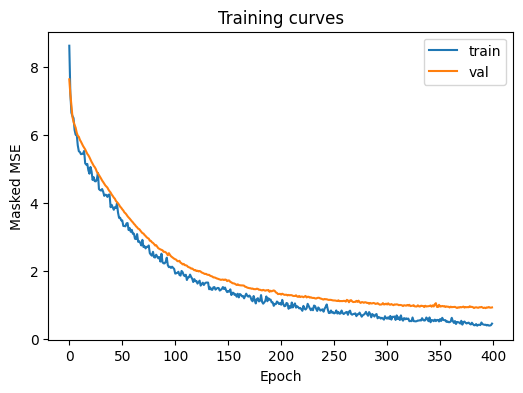

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("Epoch"); plt.ylabel("Masked MSE"); plt.title("Training curves")
plt.legend(); plt.show()


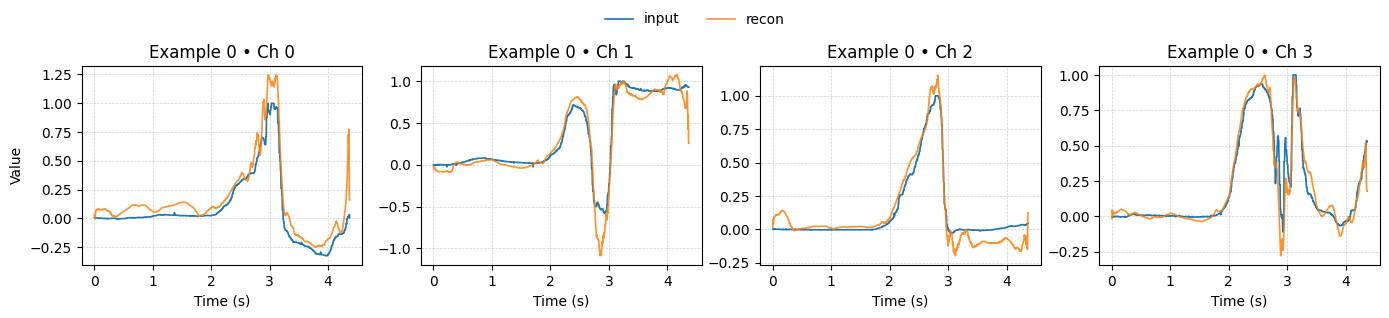

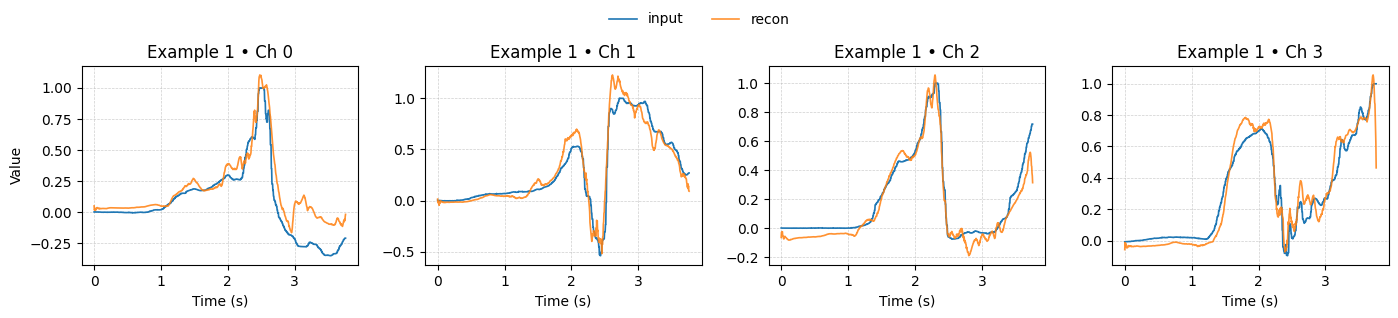

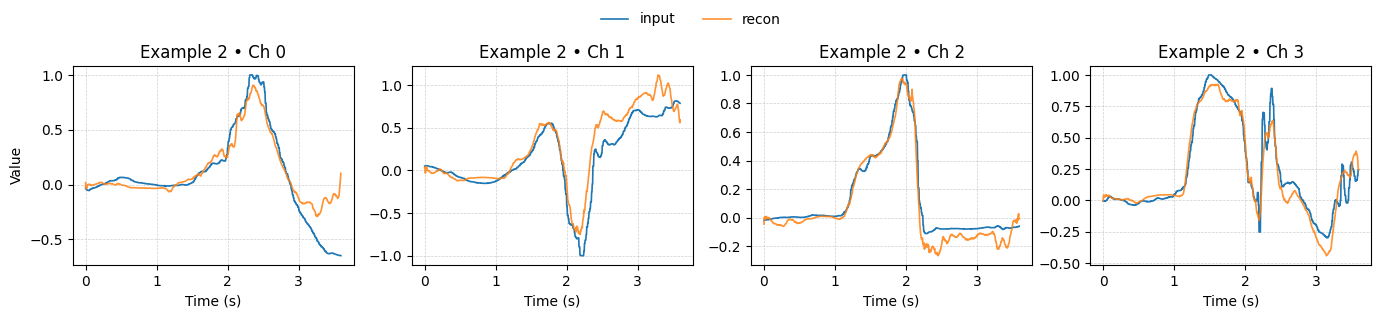

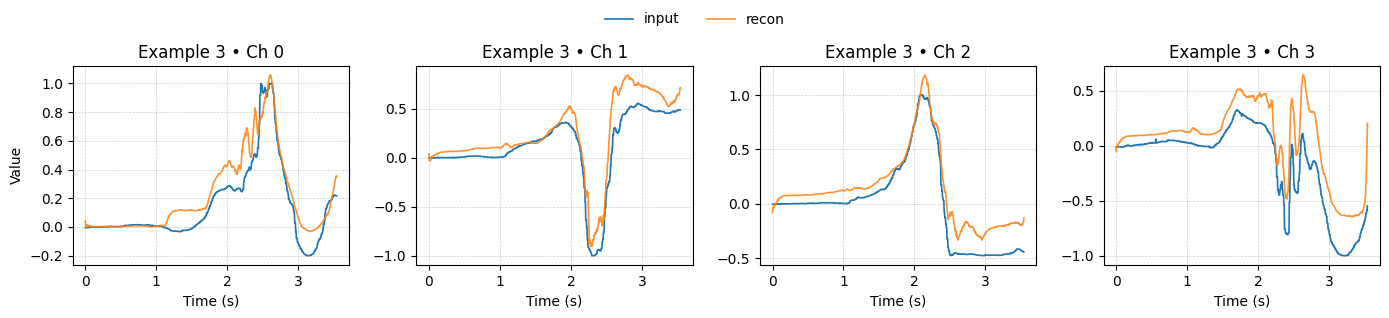

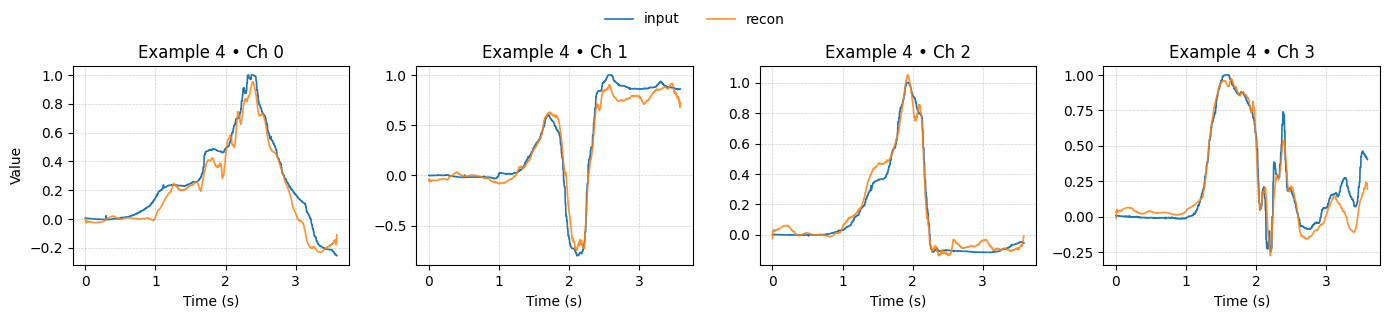

In [130]:
def show_examples(
    model,
    loader,
    ch_mean: torch.Tensor,
    ch_std:  torch.Tensor,
    device: torch.device = None,
    n_examples: int = 3,
    max_channels: int = 4,
    channels: list[int] | None = None,   # e.g., [0, 3, 5]
    fs: float | None = None,             # sampling rate; if None, x-axis is sample index
    use_original_units: bool = True,     # True: plot in original units (denormalized)
    figsize=(14, 3.2),
):
    """
    Visualize model reconstructions for a few samples/channels.

    Parameters
    ----------
    model : torch.nn.Module
        Trained model that maps normalized input -> normalized output.
    loader : DataLoader
        Must yield (x, mask, meta) where x is (B,C,T), mask is (B,1,T) with 1 for valid timesteps.
    ch_mean, ch_std : torch.Tensor
        Per-channel stats, shape (C,). These should be the TRAIN-set stats used for normalization.
    device : torch.device | None
        Device to run on. If None, chooses CUDA if available, else CPU.
    n_examples : int
        Number of examples from one batch to visualize (capped by batch size).
    max_channels : int
        Max number of channels to plot per example.
    channels : list[int] | None
        Explicit channel indices to plot. If None, uses the first `max_channels`.
    fs : float | None
        Sampling rate in Hz for labeling the x-axis (time). If None, uses sample index.
    use_original_units : bool
        If True, denormalize model outputs and plot in original units.
    figsize : tuple
        Size for each example's figure (width, height).
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()

    # ---- helper ops (local, no globals) ----
    def normalize_batch(x, mean, std):
        return (x - mean.view(1, -1, 1)) / std.view(1, -1, 1)

    def denorm(xn, mean, std):
        return xn * std.view(1, -1, 1) + mean.view(1, -1, 1)

    # ---- get one batch ----
    with torch.no_grad():
        try:
            x, mask, _ = next(iter(loader))  # x: (B,C,T), mask: (B,1,T)
        except StopIteration:
            raise RuntimeError("DataLoader is empty; cannot visualize examples.")

        x = x.to(device).float()
        mask = mask.to(device)

        B, C, T_in = x.shape

        # choose channels to show
        if channels is None:
            n_show = min(max_channels, C)
            ch_idx = list(range(n_show))
        else:
            ch_idx = [ci for ci in channels if 0 <= ci < C]
            n_show = min(len(ch_idx), max_channels)
            ch_idx = ch_idx[:n_show]

        # normalize input for the model
        ch_mean = ch_mean.to(device)
        ch_std  = ch_std.to(device)
        x_n = normalize_batch(x, ch_mean, ch_std)

        # forward pass (normalized space)
        y_n, _ = model(x_n)  # (B,C,T_out)
        _, _, T_out = y_n.shape

        # align lengths with mask; assume mask padding at tail
        T_mask = mask.shape[-1]
        T = min(T_in, T_out, T_mask)

        # crop
        x     = x[:, :, :T]
        x_n   = x_n[:, :, :T]
        y_n   = y_n[:, :, :T]
        maskT = mask[:, :, :T].squeeze(1).bool()  # (B,T)

        # choose which space to plot
        if use_original_units:
            # denormalize model output for plotting
            y = denorm(y_n, ch_mean, ch_std)
            x_plot = x
            y_plot = y
        else:
            x_plot = x_n
            y_plot = y_n

        # number of examples to show
        E = min(n_examples, B)

        # ---- plotting ----
        for e in range(E):
            valid = maskT[e]  # (T,)
            # Most collates pad at the tail; valid is typically [True...True, False...False]
            # Use only valid timesteps:
            xe = x_plot[e, :, :][:, valid]  # (C, T_valid)
            ye = y_plot[e, :, :][:, valid]  # (C, T_valid)
            T_valid = xe.shape[-1]

            if T_valid == 0:
                print(f"[warn] example {e}: no valid timesteps after masking; skipping.")
                continue

            # time axis
            if fs is not None and fs > 0:
                t = np.arange(T_valid, dtype=float) / float(fs)
                t_label = "Time (s)"
            else:
                t = np.arange(T_valid, dtype=float)
                t_label = "Sample"

            fig, axes = plt.subplots(1, n_show, figsize=figsize, squeeze=False)
            axes = axes[0]

            for j, ci in enumerate(ch_idx):
                ax = axes[j]
                ax.plot(t, xe[ci].detach().cpu().numpy(), label="input", linewidth=1.2)
                ax.plot(t, ye[ci].detach().cpu().numpy(), label="recon", linewidth=1.2, alpha=0.85)
                ax.set_title(f"Example {e} • Ch {ci}")
                ax.set_xlabel(t_label)
                ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

                # Y label only on first subplot to reduce clutter
                if j == 0:
                    ax.set_ylabel("Value" + ("" if use_original_units else " (normalized)"))

            # one legend for the row
            handles, labels = axes[0].get_legend_handles_labels()
            fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)
            fig.tight_layout(rect=[0, 0, 1, 0.92])
            plt.show()
# Assume you already have: model, train_loader/val_loader, ch_mean, ch_std, device
show_examples(
    model=model,
    loader=val_loader,      # or train_loader
    ch_mean=ch_mean,
    ch_std=ch_std,
    device=device,
    n_examples=val_loader.batch_size,
    max_channels=4,
    channels=None,          # or a list like [0,2,5,7]
    fs=220.0,               # use your sampling rate if you want time in seconds
    use_original_units=True # set False to view normalized-space plots
)



In [131]:
def detect_time_anomalies(per_t_mse, target_fpr=1e-2, smooth=9, min_len=5):
    """
    per_t_mse: (T,) tensor
    Returns indices of anomalous intervals (start, end).
    """
    import torch
    T = per_t_mse.numel()
    # smooth a bit to stabilize
    k = torch.ones(smooth)/smooth
    sm = torch.conv1d(per_t_mse.view(1,1,-1), k.view(1,1,-1), padding=smooth//2).view(-1)

    # robust, data-driven threshold via MAD
    med = sm.median()
    mad = (sm - med).abs().median().clamp_min(1e-8)
    z = (sm - med) / (1.4826*mad)
    # pick a z that roughly matches desired FPR
    thr = torch.quantile(z, torch.tensor(1 - target_fpr))
    anom = z > thr

    # group contiguous timesteps
    idx = anom.nonzero().view(-1).tolist()
    intervals = []
    if idx:
        s = idx[0]; prev = idx[0]
        for t in idx[1:]:
            if t == prev + 1:
                prev = t
            else:
                if prev - s + 1 >= min_len:
                    intervals.append((s, prev))
                s = prev = t
        if prev - s + 1 >= min_len:
            intervals.append((s, prev))
    return intervals, sm, thr.item()


In [132]:
# =======================
# Time-local anomaly kit
# =======================
import torch, numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---- helpers: norm / baseline / intervals ----
def normalize_batch(x, mean, std):
    return (x - mean.view(1,-1,1)) / std.view(1,-1,1)

def denorm(xn, mean, std):
    return xn*std.view(1,-1,1) + mean.view(1,-1,1)

def lowpass_avg(x, k=9):
    # simple non-trainable baseline, same length
    return F.avg_pool1d(x, kernel_size=k, stride=1, padding=k//2, count_include_pad=False)

def smooth_1d(x, k=9):
    w = torch.ones(1,1,k, device=x.device)/k
    return F.conv1d(x.view(1,1,-1), w, padding=k//2).view(-1)

def contiguous_intervals(idx, min_len=5):
    if len(idx)==0: return []
    out, s, p = [], idx[0], idx[0]
    for t in idx[1:]:
        if t==p+1: p=t
        else:
            if p-s+1>=min_len: out.append((s,p))
            s=p=t
    if p-s+1>=min_len: out.append((s,p))
    return out

# ---- score a single sequence (time-local + per-channel) ----
@torch.no_grad()
def score_sequence_time(model, x, mask, ch_mean, ch_std, device, agg="mean", use_lowpass_residual=False, lp_k=9):
    """
    x:    (1,C,T) in ORIGINAL units, mask: (1,1,T)
    Returns:
      sample_mse (float),
      per_t (T,) aggregated over channels,
      per_c (C,),
      err_ct (C,T) per-channel time-local errors (MSE in normalized space),
      y (1,C,T) reconstruction in ORIGINAL units
    """
    model.eval()
    x = x.to(device).float(); mask = mask.to(device).float()
    x_n = normalize_batch(x, ch_mean.to(device), ch_std.to(device))

    # Optionally work in residual space (helps highlight sharp anomalies)
    if use_lowpass_residual:
        base = lowpass_avg(x_n, k=lp_k)
        x_in = x_n
        y_n, _ = model(x_in)               # model predicts residual or full; we compare residuals
        x_cmp = x_n - base
        y_cmp = y_n - base
    else:
        x_in = x_n
        y_n, _ = model(x_in)               # full-band
        x_cmp = x_n
        y_cmp = y_n

    T = min(x_cmp.shape[-1], y_cmp.shape[-1], mask.shape[-1])
    x_cmp = x_cmp[..., :T]
    y_cmp = y_cmp[..., :T]
    x_n   = x_n[..., :T]
    y_n   = y_n[..., :T]
    mCT   = mask[..., :T].expand(-1, x.shape[1], -1)  # (1,C,T)

    err2_ct = ((x_cmp - y_cmp)**2) * mCT              # (1,C,T)
    denom   = mCT.sum().clamp_min(1)                  # scalar
    sample_mse = (err2_ct.sum()/denom).item()

    per_t = (err2_ct.sum(dim=1) / mCT.sum(dim=1).clamp_min(1)).squeeze(0)   # (T,)
    per_c = (err2_ct.sum(dim=2) / mCT.sum(dim=2).clamp_min(1)).squeeze(0)   # (C,)
    err_ct = err2_ct.squeeze(0).detach().cpu()                               # (C,T)

    # Recon back to ORIGINAL units for plotting
    y = denorm(y_n, ch_mean.to(device), ch_std.to(device)).detach().cpu()    # (1,C,T)

    # Aggregate across channels for time-local decision
    if agg=="mean":      per_t = per_t.detach().cpu()
    elif agg=="max":     per_t = (err_ct.max(dim=0).values).detach().cpu()
    else:                per_t = per_t.detach().cpu()

    return sample_mse, per_t, per_c.detach().cpu(), err_ct, y

# ---- fit thresholds from NORMAL validation data ----
@torch.no_grad()
def calibrate_time_thresholds(model, loader_normals, ch_mean, ch_std, device,
                              agg="mean", q_time=0.995, q_chan=0.995,
                              use_lowpass_residual=False, lp_k=9, max_batches=None):
    all_time_err = []
    all_chan_err = []
    for b, (x, mask, _) in enumerate(loader_normals):
        for i in range(x.size(0)):
            s, per_t, per_c, _, _ = score_sequence_time(
                model, x[i:i+1], mask[i:i+1],
                ch_mean, ch_std, device,
                agg=agg, use_lowpass_residual=use_lowpass_residual, lp_k=lp_k
            )
            all_time_err.append(per_t.numpy())
            all_chan_err.append(per_c.numpy())
        if max_batches and (b+1)>=max_batches: break

    all_time_err = np.concatenate(all_time_err)   # concat over time
    all_chan_err = np.vstack(all_chan_err)        # (N,C)

    thr_time = float(np.quantile(all_time_err, q_time))
    thr_chan = np.quantile(all_chan_err, q_chan, axis=0)  # per-channel
    return thr_time, thr_chan

# ---- nice visuals: overlays + shaded anomalies + heatmap ----
def plot_overlays_with_anoms(x, y, mask, anom_t_mask, fs=220.0, channels=None, max_channels=4, title="Anomaly overlay"):
    """
    x,y: (1,C,T) ORIGINAL units; mask: (1,1,T); anom_t_mask: (T,) bool
    """
    import numpy as np
    x = x.cpu(); y = y.cpu(); mask = mask.cpu().bool()
    B,C,T = x.shape
    T = min(T, y.shape[-1], mask.shape[-1])
    x = x[0,:,:T]; y = y[0,:,:T]; m = mask[0,0,:T]
    t = np.arange(T)/fs

    ch_idx = list(range(C)) if channels is None else [c for c in channels if 0<=c<C]
    ch_idx = ch_idx[:max_channels]

    fig, axes = plt.subplots(1, len(ch_idx), figsize=(14,3.2), squeeze=False)
    axes = axes[0]
    for j, ci in enumerate(ch_idx):
        ax = axes[j]
        xi = x[ci, m]; yi = y[ci, m]
        tt = t[m]
        ax.plot(tt, xi, label="input", linewidth=1.2)
        ax.plot(tt, yi, label="recon", linewidth=1.2, alpha=0.9)

        # shade anomalous times
        an = anom_t_mask[:len(m)]
        an = an & m.numpy()
        # turn into contiguous spans on time axis
        idx = np.where(an)[0].tolist()
        for s,e in contiguous_intervals(idx, min_len=5):
            ax.axvspan(t[s], t[e], alpha=0.18, lw=0, color="tab:red")

        ax.set_title(f"Ch {ci}")
        ax.set_xlabel("Time (s)")
        if j==0: ax.set_ylabel("Value")
        ax.grid(True, ls="--", lw=0.5, alpha=0.6)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)
    fig.suptitle(title); fig.tight_layout(rect=[0,0,1,0.92]); plt.show()

def plot_error_heatmap(err_ct, mask, fs=220.0, title="Per-channel time-local error"):
    """
    err_ct: (C,T) (normalized-space MSE); mask: (1,1,T)
    """
    import numpy as np
    C,T = err_ct.shape
    T = min(T, mask.shape[-1])
    m = mask[0,0,:T].cpu().numpy().astype(bool)
    e = err_ct[:, :T].numpy()
    e[:, ~m] = np.nan

    extent = [0, T/fs, C-0.5, -0.5]  # time on x
    plt.figure(figsize=(12, 3.2))
    plt.imshow(e, aspect='auto', interpolation='nearest', extent=extent)
    plt.colorbar(label="MSE (norm space)")
    plt.xlabel("Time (s)"); plt.ylabel("Channel")
    plt.title(title); plt.tight_layout(); plt.show()

# ---- one-stop inference + visualization for a sample ----
@torch.no_grad()
def run_anomaly_demo(model, x, mask, ch_mean, ch_std, device,
                     thr_time, thr_chan=None, fs=220.0,
                     agg="mean", smooth_k=9, min_len=5,
                     use_lowpass_residual=False, lp_k=9,
                     channels=None, max_channels=4,
                     title_prefix=""):
    s, per_t, per_c, err_ct, y = score_sequence_time(
        model, x, mask, ch_mean, ch_std, device,
        agg=agg, use_lowpass_residual=use_lowpass_residual, lp_k=lp_k
    )
    # smooth and threshold time-local score
    per_t_s = smooth_1d(per_t, k=smooth_k)
    anom_t_mask = (per_t_s > thr_time).cpu().numpy()
    # plot overlays with shaded anomalies
    plot_overlays_with_anoms(x, y, mask, anom_t_mask, fs=fs,
                             channels=channels, max_channels=max_channels,
                             title=f"{title_prefix} score={s:.4f} (thr={thr_time:.4f})")
    # per-channel heatmap
    plot_error_heatmap(err_ct, mask, fs=fs, title=f"{title_prefix} error heatmap")
    # optional: per-channel flags
    if thr_chan is not None:
        ch_flags = (per_c.numpy() > thr_chan).tolist()
    else:
        ch_flags = None
    return dict(sample_score=s, per_t=per_t, per_c=per_c, err_ct=err_ct, anom_time_mask=anom_t_mask, y=y, ch_flags=ch_flags)


thr_time: 0.8165789464116089


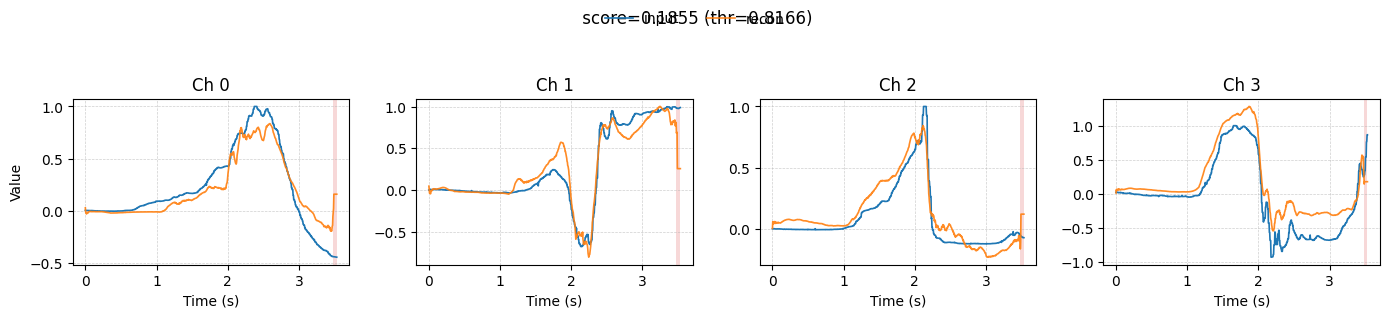

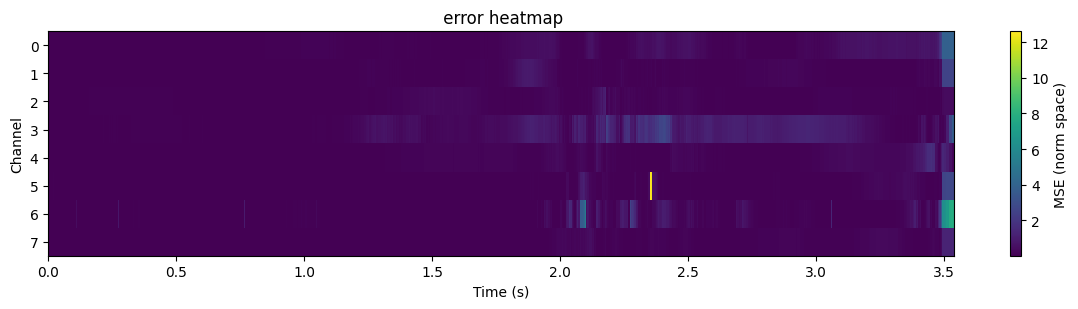

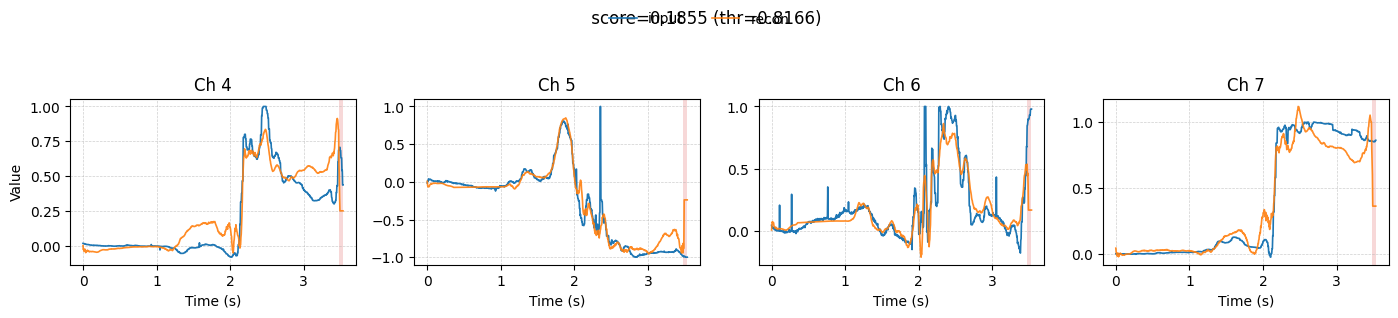

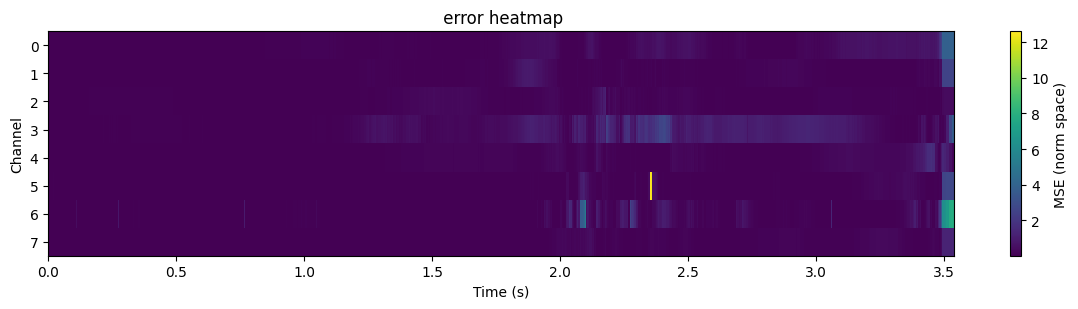

In [133]:
thr_time, thr_chan = calibrate_time_thresholds(
    model, val_loader, ch_mean, ch_std, device,
    agg="mean", q_time=0.995, q_chan=0.995,
    use_lowpass_residual=False, lp_k=9
)
print("thr_time:", thr_time)

# 2) Score a BAD sample and visualize time-local anomalies
x_bad, m_bad, _ = next(iter(bad_loader))   # (B,C,T), (B,1,T)
i = 0
out = run_anomaly_demo(
    model, x_bad[i:i+1], m_bad[i:i+1],
    ch_mean, ch_std, device,
    thr_time=thr_time, thr_chan=thr_chan,
    fs=220.0,                     # set your sampling rate
    agg="mean", smooth_k= 9, min_len= int(0.02*220),
    use_lowpass_residual=False,   # set True if you trained/scored on residuals
    lp_k=9,
    channels=[0,1,2,3], max_channels=4
)
out = run_anomaly_demo(
    model, x_bad[i:i+1], m_bad[i:i+1],
    ch_mean, ch_std, device,
    thr_time=thr_time, thr_chan=thr_chan,
    fs=220.0,                     # set your sampling rate
    agg="mean", smooth_k= 9, min_len= int(0.02*220),
    use_lowpass_residual=False,   # set True if you trained/scored on residuals
    lp_k=9,
    channels=[4,5,6,7], max_channels=4
)